# FINAL PROJECT NOTEBOOK - GROUP

## Group Members: Brandon Hoover and Ertan Li
#### Data Sets - CrimeData & 2020 Census Population + (insert) (insert)

Datasets: 

Arrest Data: https://data.wprdc.org/dataset/arrest-data/resource/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f
- CSV of Arrest Data for neighborhoods of Pittsburgh during the years 2016-2023. 
- Relevent Columns are INCIDENTNEIGHBORHOOD & ARRESTTIME
- Only includes incidents dealing with City of Pittsburgh Police, unafiliated units, such as campus police are not listed.

Neighborhood Population: https://data.wprdc.org/dataset/2020-census-redistricting-data-extracts/resource/a8414ed5-c50f-417e-bb67-82b734660da6
- CSV of different measures of population pulled from the 2010 & 2020 census respectively.
- Relevant Columns are 2020_Total_Population & Neighborhood
- Also includes population shifts by demographic, positive for increase, negative for decrease.

(insert)

(insert)

## Introduction 

#### Motivation

Our goal was to give people that are potentially interested in moving to the City of Pittsburgh a useful metric that accurately gauges high quality neighborhoods as well as simultaenously answering the challenging question of "What is the best neighborhood in Pittsburgh?"

#### SubMetric - CrimeRate

Theory: It is widely agreed that a neighborhood with a low crime rate is more favorable than a neighborhood with a high crime rate. Under that assumption when evalutating the best neighborhood we chose to incorporate the rate of crimes per capita for every neighborhood in Pittsburgh. To accomplish this goal we are using two datasets, Pittsburgh Arrest Data and 2020 Census Data to gather two pieces of information which are the number of arrests and total population of each neighborhood. 

The reason for requiring both pieces of information is that while for instance Southside might initally appear to have a higher Crimerate than Bloomfield, its relative to the amount of people living there since an increase in population enevitably leads to more arrests. So to balance the data we are going to be dividing the *number of arrests* by the *total population* of each respective neighborhood with the result being our submetric we are going to aptly named **CrimeRate**.


#### SubMetric - Housing Data


Ertan insert theory here with point values 


#### SubMetric - Grocery Stores 

Ertan insert Theory here 


### Overall Metric: Neighborhood Quality (NQ)

As we started gathering our data it became evident that we would need to develop a system to give each dataset its proper weight as the submetrics we were calculating had different scales of measurement. That is where we came up with a points system where we would give certain aspects of the data a point value and if the neighborhood had said favorable characteristics, it would earn that point value associated. Next we combine the point values earned into a total score and that is what we have deemed our overall metric, Neighborhood Quality. NQ is a combination of our three submetrics, CrimeRate, Housing (LandValue), and number of Grocery Stores. 

This is what we would call a beta test of NQ as you certainly could add even more submetrics to get an even better picture of the highest quality neighborhoods Pittsubrgh has to offer. Our metric is versatile because it allows for the addition of submetrics without the need to revisit the previously established score since each neighborhood will grow in point score (NQ) at the same rate. 


The point values are distributed as follows:

GROCERY STORES - insert 

HOUSING - insert

CRIME RATE - Based on percentage ranges listed below:

- \> .25% = 60 Points
- \> .5% = 45  Points
- \> 1% = 30 Points
- \> 3% = 15 Points
- \> 5% = 0 Points






















## CrimeRate Implementation

In [ ]:

import pandas as pd
import json
from datetime import datetime, timedelta, date
import requests
import matplotlib.pyplot as plt 



# finding number of Arrests - SQL query 
wprdc_api_endpoint = "https://data.wprdc.org/api/3/action/datastore_search_sql"

# id of table 
resource_id = "e03a89dd-134a-4ee8-a2bd-62c40aeebc6f"
resource_id2 = "a8414ed5-c50f-417e-bb67-82b734660da6"

# num Pitt neighborhoods - 103 from wikipedia

jDict = {}

# FOR numberOfCrimes per neighborhood
with open("Neighborhood.txt", "r") as file:

    for i in range(103):
        # read in a neighborhood - might have \n (check)
        neighborhood = file.readline().strip()
        
        print(f"neighborHood {neighborhood}, {i} \n\n")

        # AND - all conditions in WHERE must be true
        # LIKE - looking for a specified pattern %means any number of chars

        # translation 
        # Select/count all incident_loc from wprdc, where there was an arrest in a neighborhood that in between 2015-present, in descending order
        query = """
            SELECT "INCIDENTNEIGHBORHOOD", COUNT(*) as count
            FROM "{}"
            WHERE "INCIDENTNEIGHBORHOOD" LIKE '{}' 
                AND "ARRESTTIME" BETWEEN '2023-01-01T00:00:00' AND '2023-12-31T23:59:59'
            GROUP BY "INCIDENTNEIGHBORHOOD"
            ORDER BY count DESC
            
        """.format(resource_id, neighborhood)
        # get Request, (nested inside URL) 
        response = requests.get(wprdc_api_endpoint, {'sql': query}, verify=False)
        
        # loads into python dict {result -> records}
        response_data = json.loads(response.text)

        # If you got a good SQL query add it to python dictionary 
        if 'result' in response_data and 'records' in response_data['result']:
            for record in response_data['result']['records']:
                neighborhood_name = record["INCIDENTNEIGHBORHOOD"]
                count = record["count"]
                jDict[neighborhood_name] = count
        else:
            print(f"No data found for neighborhood: {neighborhood}")
        #jDict[neighborhood_name] = counT     


# Convert dictionary to DataFrame
df = pd.DataFrame(list(jDict.items()), columns=["Neighborhood", "Count"])

# Print the number of rows
print(df.shape[0], "rows total")
print(df.columns)
df.head()


jDict2 = {}
# FOR total population 
with open("Neighborhood.txt", "r") as file:

    for i in range(103):
        # read in a neighborhood - might have \n (check)
        neighborhood = file.readline().strip()
        
        print(f"neighborhood {neighborhood}, {i} \n\n")

        # translation 
        # Select 2020_Total_Pop column from table, where the neighborhood = to neighborhood_var, 
        query = """
            SELECT "2020_Total_Population"
            FROM "{}"
            WHERE "Neighborhood" LIKE '{}'
        """.format(resource_id2, neighborhood)
        # get Request, (nested inside URL) 
        response2 = requests.get(wprdc_api_endpoint, {'sql': query}, verify=False)
        
        # failing on subsequent sql calls 
        if response2.status_code == 200:
            print("we got somethin! \n ")
      

        # loads into python dict {result -> records}
        response_data2 = json.loads(response2.text)

        # If you got a good SQL query add it to python dictionary 
        if 'result' in response_data2 and 'records' in response_data2['result']:
            for record2 in response_data2['result']['records']:
                
                pop = record2["2020_Total_Population"]
                jDict2[neighborhood] = pop
        else:
            print(f"No POPULATION DATA found for neighborhood: {neighborhood}")



# Convert dictionary to DataFrame
df2 = pd.DataFrame(list(jDict2.items()), columns=["Neighborhood" , "Total_Population"])

# Print the number of rows
print(df2.shape[0], "rows total")
print(df2.columns)
df2.head()

# write to file should have total pop column
df.to_csv('data.csv', index=False) 
df2.to_csv('data2.csv', index=False)


#--------- TOP 5 HIGHEST CRIME RATES -------------
# Chateau :  2.5789473684210527
#South Shore :  0.8620689655172413
#Homewood West :  0.07165109034267912
##California-Kirkbride :  0.06205923836389281
#Hays :  0.04984423676012461




In [3]:
# ANALYZING DATA FRAME AND CALCULATING SUBMRETRIC 

# they are environment variables so I should be able to execute code in seperate code blocks

df3 = pd.merge(df, df2, on="Neighborhood")
df3 = df3.sort_values('Count', ascending=False)
df3.head(30)

# calculating submetric - crimeRate 
top5_crimeRate = [100, 100, 100, 100, 100]
top5_neigh = ["", "", "", "", ""]

for index, row in df3.iterrows():
    #print(row['Count'], row['Total_Population'])
    
    crimeRate = row['Count'] / int(row['Total_Population'])
    
    # just need the top 5 highest crime rates because were going for one best neighborhood
    for i in range(len(top5_crimeRate)):
        if (top5_crimeRate[i] > crimeRate):                        
            top5_crimeRate[i] = crimeRate                       # new crimeRate found exit for
            top5_neigh[i] = row['Neighborhood']
            break
        
        
print(top5_crimeRate)
print(top5_neigh)

print("\n\n--------- TOP 5 LOWEST CRIME RATES -------------\n",top5_neigh[0], ": ", top5_crimeRate[0])
print(top5_neigh[1], ": ", top5_crimeRate[1])
print(top5_neigh[2], ": ", top5_crimeRate[2])
print(top5_neigh[3], ": ", top5_crimeRate[3])
print(top5_neigh[4], ": ", top5_crimeRate[4])


#--------- TOP 5 HIGHEST CRIME RATES -------------
# Chateau :  2.5789473684210527
#South Shore :  0.8620689655172413
#Homewood West :  0.07165109034267912
##California-Kirkbride :  0.06205923836389281
#Hays :  0.04984423676012461



[0.0024412829362740972, 0.0027675276752767526, 0.002926829268292683, 0.004119464469618949, 0.006683375104427736]
['Squirrel Hill North', 'Morningside', 'Oakwood', 'Regent Square', 'Upper Lawrenceville']


--------- TOP 5 LOWEST CRIME RATES -------------
 Squirrel Hill North :  0.0024412829362740972
Morningside :  0.0027675276752767526
Oakwood :  0.002926829268292683
Regent Square :  0.004119464469618949
Upper Lawrenceville :  0.006683375104427736


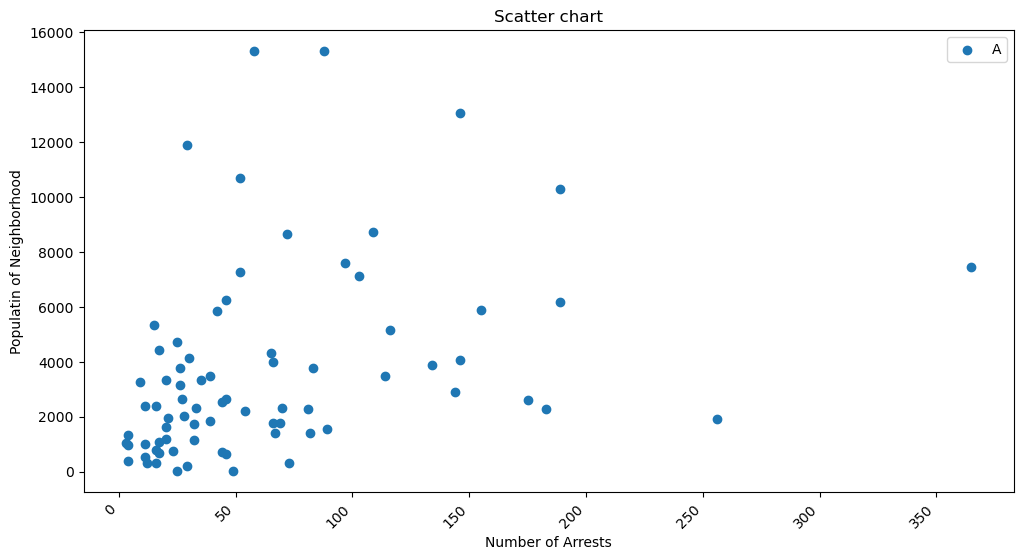

In [4]:
# VISUALIZING DATA

# need to resort data and turn string data (Total_Population) into ints that can be measured

# Ensure Total_Population is numeric
df3['Total_Population'] = pd.to_numeric(df3['Total_Population'])

df3 = df3.sort_values('Total_Population')

#print(df3.head(30))

# data to display on plots 
x = df3['Count']
y = df3['Total_Population']

# Plot scatter chart
plt.figure(figsize=(12, 6))  # Increase figure size 
plt.scatter(x, y)            # plot graph

# Rotate x-axis labels so you can read it
plt.xticks(rotation=45, ha='right')  

# Labels and things
plt.legend("A")
plt.title("Scatter chart")
plt.xlabel("Number of Arrests")
plt.ylabel("Populatin of Neighborhood")
plt.show()

## Housing Implementation

In [ ]:
# need visual for explanation and calculation 

## Grocery Store Implementation

In [ ]:
## Insert I guess your excel check rubric need visual at the very least 

## Conclusions


Brandon's Conclusion: 

Before tabulating the point values for the best results from each submetric, there came a clear front runner for our best neighborhood, and that was **Squirrel Hill North**. Having placed in the Top 5 for each submetric it would induibably have a top NQ rating compared to the other neighborhoods, and that proved to be the case with a score of (INSERT SCORE). We tally that rating by utilizing the results we have gained from manipulating these data sets, which at first glance were enormous and ambiguous, to the point where we can now accurately state trends and conclusions. For instance Squirrel Hill earned a full 60 points in the CrimeRate submetric, the maximum to help bolster its score.

Additionally, through the scatterplot that was achieved through matplot in the CrimeRate implementation, we saw very loosely (low R-Value correlation) that as the population of a nieghborhood increased, so did the number of Arrests that occured in the one year period studied (2023). This supports our initial hypothesis of requiring a fourth dataset, 'Neighborhood Population' to help counteract this problem and get reliable results. Without that the neighborhood with the highest population would presumably have the highest CrimeRate. 

Surprisingly that was not the case and that leads me to my next point, our outliers for CrimeRate. Our two largest outliers for CrimeRate were South Side Flats (350 arrests) and Chateau with a 250% arrest rate per capita. A possible explanation towards these strange statistics is a factor that was not considered, and that is commerical businesses. For instance, it makes sense that the South Side Flats has a high crime rate because of the type of commerical businesses that attract potentially illegal activites, such as the 'Night Life' in South Side and the bars in Chateau which only has a population of 20 people (49 arrested).

To summarize, what I believe my partner and I have accomplished here is calculate maybe not the **Best** quality neighborhood in Pittsburgh but instead the **richest** neighborhood in Pittsburgh since it has a .02% CrimeRate, the best ameneties (Grocery/Convenience Stores), and an incredibly high Land Value for purchasing new homes. So while objectively this may appear to be the prefferred option for potential new Pittsburghers, it is simply out of reach for the majority of Americans to even consider. 